In [27]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
import pylab

plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

%matplotlib inline

In [28]:
df = pd.read_csv("./data/twitter_combined.txt.gz", compression='infer', sep=" ", header=None, names=["a", "b"])
print(len(df))
df.head()

2420766


,a,b
0,214328887,34428380
1,17116707,28465635
2,380580781,18996905
3,221036078,153460275
4,107830991,17868918


In [29]:
nodes = list(set(df["a"]) | set(df["b"]))
nodes.sort()
nodes[:20]
nodes_to_idx = {n:i for i,n in enumerate(nodes)}

df_o = df
df = pd.DataFrame({"a": df["a"].apply(lambda x: nodes_to_idx[x]), 
                   "b": df["b"].apply(lambda x: nodes_to_idx[x])})
df.head()   

,a,b
0,64848,33444
1,15266,30189
2,76829,19302
3,65515,58679
4,52420,16766


In [30]:
e = len(df)
v = len(np.unique(df.a))
v = max(np.max(np.unique(df.a)), np.max(np.unique(df.b))) + 1
print(e,v)

2420766 81306


In [31]:
facebook2 = csr_matrix((np.ones(e), (df.a, df.b)), shape=(v,v))
facebook2 = 1 * ((facebook2 + facebook2.T) !=0)

In [32]:
import networkx as nx
import metis

In [33]:
%time g = nx.from_scipy_sparse_matrix(facebook2)

CPU times: user 33.9 s, sys: 184 ms, total: 34.1 s
Wall time: 34.1 s


# Ancienne méthode

n_clusters = int(facebook2.shape[0]/100)
print(n_clusters)

%time (edgecuts, parts) = metis.part_graph(g, n_clusters, objtype='cut', ufactor=1000, contig=True, niter=100)
print(edgecuts, len(parts), len(np.unique(parts)))
parts = np.array(parts)

# Nouvelle méthode

In [34]:
n_clusters = int(facebook2.shape[0]/100)
print(n_clusters)

%time adj = metis.adjlist_to_metis(list(df.to_records(index=None)))

%time (edgecuts, parts) = metis.part_graph(g, n_clusters, objtype='cut', ufactor=1000, contig=True, niter=100)
print(edgecuts, len(parts), len(np.unique(parts)))
parts = np.array(parts)

813
CPU times: user 30.7 s, sys: 60 ms, total: 30.8 s
Wall time: 30.8 s
CPU times: user 16.1 s, sys: 36 ms, total: 16.1 s
Wall time: 16.2 s
613363 81306 810


In [35]:
nodes = pd.DataFrame({"part": parts})
nodes.groupby("part").size().describe()

count    810.000000
mean     100.377778
std       55.220565
min       18.000000
25%       50.000000
50%       75.500000
75%      145.750000
max      200.000000
dtype: float64

Cluster #6 is of size 68
pseudo-degree of cluster is 267


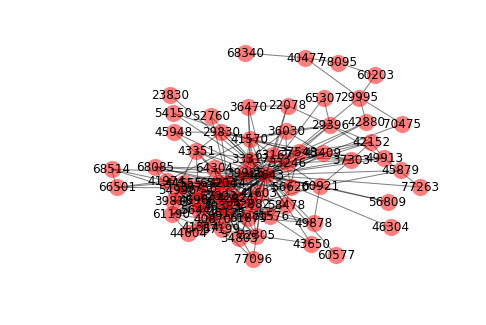

In [36]:
from IPython.html.widgets import interact
import graph_helpers
from imp import reload
reload(graph_helpers)

@interact
def plot(cl = ('6', '7', '8', '10', '20', '30'), degree=("0", "1", "2"), layout=("spring", "std", "spectral")):
    cl = int(cl)
    print("Cluster #%d is of size %d" % (cl, (parts == cl).sum()))
    
    print("pseudo-degree of cluster is %d" % graph_helpers.get_deg_sub(facebook2, parts == cl))
    
    graph_helpers.plot_subgraph_links(facebook2, parts == cl, int(degree), layout=layout, graph=g)

count     813.000000
mean      550.134071
std       690.072280
min         0.000000
25%       162.000000
50%       328.000000
75%       636.000000
max      5473.000000
dtype: float64


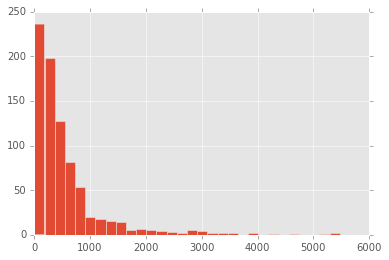

In [37]:
all_degs = [graph_helpers.get_deg_sub(facebook2, parts == i) for i in range(n_clusters)]
print(pd.Series(all_degs).describe())
_ = plt.hist(all_degs, bins=30)

In [38]:
cl6 = np.where(parts == 6)[0]
df[(df.a.isin(cl6)) & ~ (df.b.isin(cl6))]

,a,b
1666,29830,10140
3368,29830,50398
3818,29830,41263
6894,29830,15898
6977,29830,3946
7632,29830,13823
7916,29830,16396
404136,78095,10259
404147,60203,57047
404221,40477,56478


In [39]:
df[(df.b.isin(cl6)) & ~ (df.a.isin(cl6))]

,a,b
204,3946,29830
1141,15898,29830
2213,70858,29830
2664,63749,29830
4236,70182,29830
4655,13823,29830
5702,63960,29830
6121,10140,29830
7432,16396,29830
405002,64326,29995


In [40]:
clusters = parts

### Evaluation de performance

In [41]:
from gmet import group_vertex_degree, group_edge_degree

%time metrics = pd.DataFrame({'sz': [(clusters == cl).sum() for cl in range(n_clusters)], \
                          'vdeg': [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)], \
                          'edeg': [group_edge_degree(facebook2, clusters == i) for i in range(n_clusters)]})

metrics["vratio"] = metrics.vdeg / metrics.sz
metrics["eratio"] = metrics.edeg / metrics.sz

metrics.describe()

CPU times: user 1min 15s, sys: 0 ns, total: 1min 15s
Wall time: 1min 15s


,edeg,sz,vdeg,vratio,eratio
count,813.000000,813.000000,813.000000,810.000000,810.000000
mean,1508.880689,100.007380,550.134071,5.805142,13.894220
std,2488.276302,55.453881,690.072280,5.850398,13.518124
min,0.000000,0.000000,0.000000,0.024390,0.054945
25%,435.000000,50.000000,162.000000,2.021579,5.381963
50%,781.000000,75.000000,328.000000,4.115000,10.457006
75%,1414.000000,145.000000,636.000000,7.570556,17.895882
max,27714.000000,200.000000,5473.000000,47.388889,138.570000


In [42]:
from imp import reload
import gmet
reload(gmet)

metrics["ratio_cut"] = gmet.ratio_cut_list(facebook2, clusters)
metrics["n_cut"] = gmet.n_cut_list(facebook2, clusters)

metrics.describe()

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
count,813.000000,813.000000,813.000000,810.000000,810.000000,810.000000,810.000000
mean,1508.880689,100.007380,550.134071,5.805142,13.894220,13.894220,0.505700
std,2488.276302,55.453881,690.072280,5.850398,13.518124,13.518124,0.247800
min,0.000000,0.000000,0.000000,0.024390,0.054945,0.054945,0.007321
25%,435.000000,50.000000,162.000000,2.021579,5.381963,5.381963,0.298022
50%,781.000000,75.000000,328.000000,4.115000,10.457006,10.457006,0.500622
75%,1414.000000,145.000000,636.000000,7.570556,17.895882,17.895882,0.716412
max,27714.000000,200.000000,5473.000000,47.388889,138.570000,138.570000,0.954453


In [43]:
metrics[metrics.sz >= 4].describe()

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
count,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000,810.000000
mean,1514.469136,100.377778,552.171605,5.805142,13.894220,13.894220,0.505700
std,2491.185433,55.220565,690.535427,5.850398,13.518124,13.518124,0.247800
min,5.000000,18.000000,2.000000,0.024390,0.054945,0.054945,0.007321
25%,438.250000,50.000000,163.250000,2.021579,5.381963,5.381963,0.298022
50%,786.500000,75.500000,331.500000,4.115000,10.457006,10.457006,0.500622
75%,1414.000000,145.750000,639.750000,7.570556,17.895882,17.895882,0.716412
max,27714.000000,200.000000,5473.000000,47.388889,138.570000,138.570000,0.954453


In [45]:
metrics[(metrics.sz >=4) & (metrics.n_cut < 0.2) & (metrics.ratio_cut < 1)]

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
59,42,104,41,0.394231,0.403846,0.403846,0.053985
71,55,96,22,0.229167,0.572917,0.572917,0.059718
116,72,108,37,0.342593,0.666667,0.666667,0.020991
119,5,91,5,0.054945,0.054945,0.054945,0.007321
125,92,142,34,0.239437,0.647887,0.647887,0.100877
127,129,200,39,0.195000,0.645000,0.645000,0.020525
148,63,104,44,0.423077,0.605769,0.605769,0.125249
152,24,67,20,0.298507,0.358209,0.358209,0.078947
158,38,63,25,0.396825,0.603175,0.603175,0.029921
612,48,69,22,0.318841,0.695652,0.695652,0.057971
